# Advanced Certification Programme in AI and MLOps
## A programme by IISc and TalentSprint
### Mini-Project: Lung Segmentation of Chest X-Ray dataset using DeepLabV3+

## Learning Objectives:

At the end of the experiment, you will be able to:

- understand, prepare, and visualize the the dataset containing image and corresponding masked image used for segmentation
- implement DeepLabV3+ architecture
- create a masked image (prediction)

## Introduction

Semantic segmentation is a computer vision task that involves dividing an image into different regions, each of which is labeled with a semantic category. The goal of semantic segmentation is to enable machines to understand the content of an image at a pixel level, by assigning a label to each individual pixel based on the object or region it belongs to.

This technique is widely used in many applications such as self-driving cars, medical image analysis, and object recognition in robotics. It helps to extract meaningful information from images and to understand the relationships between objects and their environment.

The below figure shows how semantic segmentation differs from other algorithms, such as object detection.

<br>
<img src='https://cdn.iisc.talentsprint.com/AIandMLOps/Images/segmentation_vs_other_algos.jpeg' width=700px>
<br><br>

Moreover, in contrast to object detection, which detects and localizes objects within an image, semantic segmentation is more precise and detailed. It provides a much more granular understanding of the content of an image, allowing for more advanced and accurate applications.

## Dataset

*  The Chest X-Ray dataset is made up of images and segmentated mask from two diffrent sources - Shenzhen and Montgomery dataset
*  The CXR_png folder consists of Chest X-Rays and the masks folder has the segmented mask
*  There are 704 images with their masks mapped with each other  

<br>
$\quad$<img src='https://cdn.extras.talentsprint.com/AIandMLOps/Images/semantic_segmentation.png' width=700px>
<br><br>


## Problem Statement

Perfrom the lungs segmentation on Chest X-Ray dataset using DeepLabV3+ model.

## Grading = 10 Points

In [5]:
#@title Download the data
!wget https://cdn.iisc.talentsprint.com/AIandMLOps/MiniProjects/Datasets/LungSegmentation.zip
!unzip -qq LungSegmentation.zip
print("Data Downloaded Successfuly!!")

--2024-05-31 16:34:13--  https://cdn.iisc.talentsprint.com/AIandMLOps/MiniProjects/Datasets/LungSegmentation.zip
Resolving cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)... 172.105.52.210
Connecting to cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)|172.105.52.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139904834 (133M) [application/zip]
Saving to: ‘LungSegmentation.zip’

LungSegmentation.zi 100%[===================>] 133.42M  10.0MB/s    in 15s     

2024-05-31 16:34:29 (9.11 MB/s) - ‘LungSegmentation.zip’ saved [139904834/139904834]

Data Downloaded Successfuly!!


### Import required packages

In [131]:
import os
import cv2
import numpy as np
from glob import glob
from PIL import Image
from scipy.io import loadmat
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### **PART-A**

### Data Visualization (1 point)

#### Image Visualization
Visualize one of the Chest X-Ray image and its segmented label image.

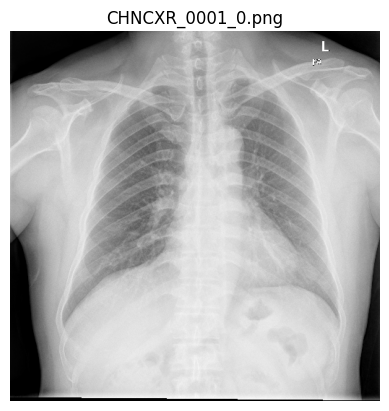

In [132]:
# Visualize an image
image_dir = "./LungSegmentation/CXR_png"
mask_dir = "./LungSegmentation/masks"
input_img_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(".png")])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir) if fname.endswith(".png")])

plt.axis("off")
plt.imshow(Image.open(input_img_paths[0]), cmap='gray')
plt.title(input_img_paths[0].split('/')[-1])
plt.show()

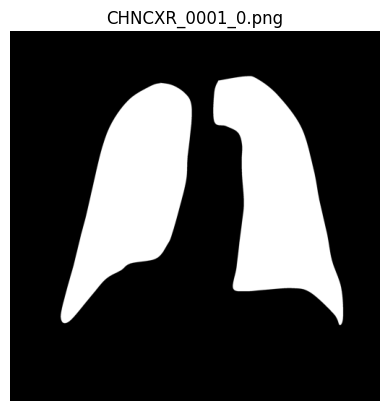

In [133]:
# Visualize a semantic part segmentation label image
plt.axis("off")
plt.imshow(Image.open(mask_paths[0]), cmap='gray')
plt.title(mask_paths[0].split('/')[-1])
plt.show()

In [134]:
image = cv2.imread(input_img_paths[0], cv2.IMREAD_UNCHANGED)
print(f"Shape of image: {image.shape}")

image = cv2.imread(mask_paths[0], cv2.IMREAD_UNCHANGED)
print(f"Shape of mask: {image.shape}")

Shape of image: (512, 512, 3)
Shape of mask: (512, 512)


In [135]:
image = cv2.imread(input_img_paths[0])

# Split the image into its channels
b, g, r = cv2.split(image)

# Find the minimum and maximum pixel values in each channel
min_val_b, max_val_b, _, _ = cv2.minMaxLoc(b)
min_val_g, max_val_g, _, _ = cv2.minMaxLoc(g)
min_val_r, max_val_r, _, _ = cv2.minMaxLoc(r)

# Print the range of pixel values for each channel
print("Blue channel range: {}-{}".format(min_val_b, max_val_b))
print("Green channel range: {}-{}".format(min_val_g, max_val_g))
print("Red channel range: {}-{}".format(min_val_r, max_val_r))

Blue channel range: 0.0-255.0
Green channel range: 0.0-255.0
Red channel range: 0.0-255.0


In [136]:
import pandas as pd
all_images = sorted(input_img_paths)
all_masks = sorted(mask_paths)
print(f"No. of normal cases: {pd.Series([all_images[i].split('/')[-1].split('.')[0].endswith('0') for i in range(len(all_images))]).value_counts()[True]}")
print(f"No. of abnormal cases: {pd.Series([all_images[i].split('/')[-1].split('.')[0].endswith('0') for i in range(len(all_images))]).value_counts()[False]}")

No. of normal cases: 359
No. of abnormal cases: 345


In [137]:
print(f"No. of images from Montgomery dataset: {pd.Series([all_images[i].split('/')[-1].split('.')[0].startswith('M') for i in range(len(all_images))]).value_counts()[True]}")

No. of images from Montgomery dataset: 138


In [138]:
print(f"No. of normal images from Montgomery dataset: {pd.Series([(all_images[i].split('/')[-1].split('.')[0].startswith('M')) & (all_images[i].split('/')[-1].split('.')[0].endswith('0'))for i in range(len(all_images))]).value_counts()[True]}")

No. of normal images from Montgomery dataset: 80


In [139]:
print(f"No. of abnormal images from Montgomery dataset: {pd.Series([(all_images[i].split('/')[-1].split('.')[0].startswith('M')) & (all_images[i].split('/')[-1].split('.')[0].endswith('1'))for i in range(len(all_images))]).value_counts()[True]}")

No. of abnormal images from Montgomery dataset: 58


In [140]:
print(f"No. of images from Shenzhen dataset: {pd.Series([all_images[i].split('/')[-1].split('.')[0].startswith('M') for i in range(len(all_images))]).value_counts()[False]}")

No. of images from Shenzhen dataset: 566


In [141]:
print(f"No. of normal images from Shenzhen dataset: {pd.Series([(all_images[i].split('/')[-1].split('.')[0].startswith('C')) & (all_images[i].split('/')[-1].split('.')[0].endswith('0'))for i in range(len(all_images))]).value_counts()[True]}")

No. of normal images from Shenzhen dataset: 279


In [142]:
print(f"No. of abnormal images from Shenzhen dataset: {pd.Series([(all_images[i].split('/')[-1].split('.')[0].startswith('C')) & (all_images[i].split('/')[-1].split('.')[0].endswith('1'))for i in range(len(all_images))]).value_counts()[True]}")

No. of abnormal images from Shenzhen dataset: 287


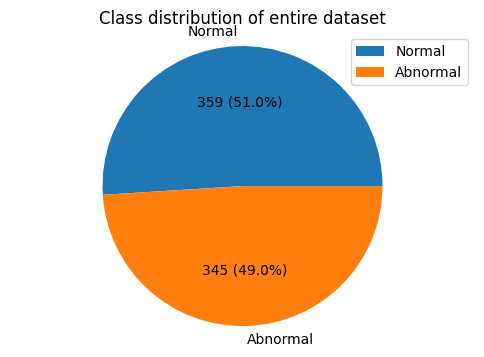

In [143]:
x_ray_count = [359, 345]
labels=['Normal', 'Abnormal']
total = sum(x_ray_count)
plt.figure(figsize=(6, 4))
plt.pie(x_ray_count, labels=labels, autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * total / 100, p), startangle=0)
plt.title('Class distribution of entire dataset')
plt.legend(loc='best')
plt.axis('equal')
plt.show()

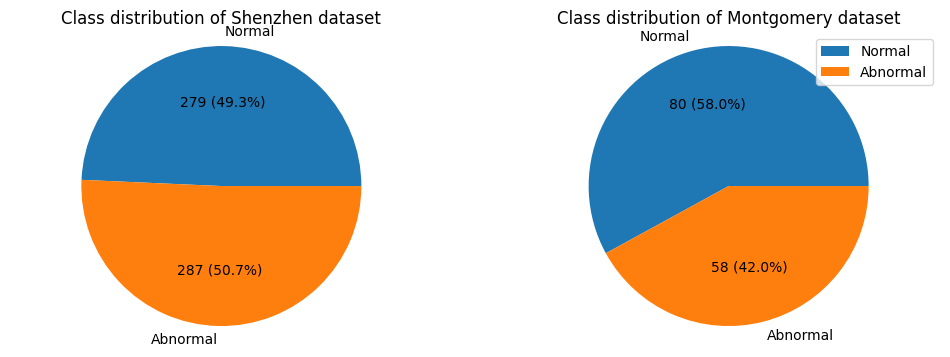

In [144]:
shenzhen = [279, 287]
montgomery = [80, 58]
labels=['Normal', 'Abnormal']
total_s = sum(shenzhen)
total_m = sum(montgomery)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].pie(shenzhen, labels=labels, autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * total_s / 100, p), startangle=0)
axs[0].set_title('Class distribution of Shenzhen dataset')
axs[1].pie(montgomery, labels=labels, autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * total_m / 100, p), startangle=0)
axs[1].set_title('Class distribution of Montgomery dataset')

axs[0].axis('equal')
axs[1].axis('equal')
plt.legend()
plt.show()

### Create a TensorFlow Dataset (1 points)
Use the image size, batch size, number of classes, and data directory as given in the below code cell.

Hint:
1. Find all the image files in the CXR_png and masks subdirectory separately. The resulting list should be sorted in ascending order.
2. Create a list of validation image, validation masks, test image, test masks, etc.
3. Create a function that reads an image file and returns a preprocessed image tensor.  

In [145]:
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 2
DATA_DIR = "./LungSegmentation"

# Find paths for all the image files in the 'CXR_png' subdirectory of the DATA_DIR directory.
# Sort the list of file paths in ascending order
all_images = sorted(input_img_paths)

# Find paths for all the mask files in the 'masks' subdirectory of the DATA_DIR directory.
# Sort the list of file paths in ascending order
all_masks = sorted(mask_paths)

# Separate normal and abnormal images and masks from the sorted list to stratify the images for better generalization as abnormal images have smaller lung size

normal_images = [all_images[i] for i in range(len(all_images)) if all_images[i].split('/')[-1].split('.')[0].endswith('0')]
normal_masks = [all_masks[i] for i in range(len(all_masks)) if all_masks[i].split('/')[-1].split('.')[0].endswith('0')]

abnormal_images = [all_images[i] for i in range(len(all_images)) if all_images[i].split('/')[-1].split('.')[0].endswith('1')]
abnormal_masks = [all_masks[i] for i in range(len(all_masks)) if all_masks[i].split('/')[-1].split('.')[0].endswith('1')]

# Create a splitter function to split the data into development and test set in 80/20 ratio and further split the development in 80/20 train and validation dataset.
def splitter(path, dev_ratio=0.8, test_ratio = 0.2, train_ratio = 0.8, val_ratio = 0.2):

    dev_end = int(dev_ratio * len(path))
    test_end = dev_end + int(test_ratio * len(path))

    train_end = int(train_ratio * dev_end)
    val_end = train_end + int(val_ratio*dev_end)

    # print(train_end, val_end, test_end)

    train_list = path[:train_end]
    val_list = path[train_end:val_end]
    test_list = path[val_end:test_end+1]

    return train_list, val_list, test_list

# Get train, val, test split using the splitter function
normal_images_train, normal_images_val, normal_images_test = splitter(normal_images)
normal_masks_train, normal_masks_val, normal_masks_test = splitter(normal_masks)

abnormal_images_train, abnormal_images_val, abnormal_images_test = splitter(abnormal_images)
abnormal_masks_train, abnormal_masks_val, abnormal_masks_test = splitter(abnormal_masks)

# Create a list of validation image files
val_images = normal_images_val + abnormal_images_val

# # Create a list of validation mask files
val_masks = normal_masks_val + abnormal_masks_val


# # Create a list of test image files
test_images = normal_images_test + abnormal_images_test

# # Create a list of test mask files
test_masks = normal_masks_test + abnormal_masks_test


# # Create a list of train image files
train_images = normal_images_train + abnormal_images_train

# # Create a list of train mask files
train_masks = normal_masks_train + abnormal_masks_train

In [146]:
print(len(normal_images))
print(len(normal_images_val + normal_images_test + normal_images_train))
print(len(abnormal_images))
print(len(abnormal_images_val + abnormal_images_test + abnormal_images_train))

359
359
345
345


In [147]:
print(f"Train set:")
[(img.split('/')[-1], mask.split('/')[-1]) for img,mask in zip(train_images[0:5], train_masks[0:5])]

Train set:


[('CHNCXR_0001_0.png', 'CHNCXR_0001_0.png'),
 ('CHNCXR_0002_0.png', 'CHNCXR_0002_0.png'),
 ('CHNCXR_0003_0.png', 'CHNCXR_0003_0.png'),
 ('CHNCXR_0004_0.png', 'CHNCXR_0004_0.png'),
 ('CHNCXR_0005_0.png', 'CHNCXR_0005_0.png')]

In [148]:
print(f"Validation set:")
[(img.split('/')[-1], mask.split('/')[-1]) for img,mask in zip(val_images[-6:-1], val_masks[-6:-1])]

Validation set:


[('CHNCXR_0645_1.png', 'CHNCXR_0645_1.png'),
 ('CHNCXR_0646_1.png', 'CHNCXR_0646_1.png'),
 ('CHNCXR_0647_1.png', 'CHNCXR_0647_1.png'),
 ('CHNCXR_0648_1.png', 'CHNCXR_0648_1.png'),
 ('CHNCXR_0649_1.png', 'CHNCXR_0649_1.png')]

In [149]:
print(f"Test set:")
[(img.split('/')[-1], mask.split('/')[-1]) for img,mask in zip(test_images[10:15], test_masks[10:15])]

Test set:


[('MCUCXR_0024_0.png', 'MCUCXR_0024_0.png'),
 ('MCUCXR_0026_0.png', 'MCUCXR_0026_0.png'),
 ('MCUCXR_0027_0.png', 'MCUCXR_0027_0.png'),
 ('MCUCXR_0028_0.png', 'MCUCXR_0028_0.png'),
 ('MCUCXR_0029_0.png', 'MCUCXR_0029_0.png')]

In [150]:
# Function to read an image file and returns a preprocessed image tensor.
# The mask argument is set to False by default, indicating that it is an image file, not a mask file.
from tensorflow import image as tf_image
from tensorflow import io as tf_io

def read_image(image_path, mask=False):

    image = tf_io.read_file(image_path)
    if mask:
        image = tf_image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf_image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf_image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf_image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])

    return image

Create a **load_data** function that takes in two arguments, **image_list** and **mask_list**, which are lists of file paths to the images and corresponding masks, respectively. It then reads in the image and mask using the **read_image** function defined earlier. The function returns a tuple of **image** and **mask**.

In [151]:
def load_data(image_list, mask_list):

    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

Create a **data_generator** function that takes in **image_list** and **mask_list** as arguments.

The function should:
- create a **tf.data.Dataset** object from the input data
- map the **load_data** function to each element in the dataset
- convert the dataset into batches of size **BATCH_SIZE**, drop any incomplete batch at the end of the dataset
- return the resulting dataset

In [152]:
# Generate train and validation set
from tensorflow import data as tf_data

def data_generator(image_list, mask_list):

    dataset = tf_data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf_data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)
test_dataset = data_generator(test_images, test_masks)

print(f"Train Dataset: {train_dataset}")
print(f"Val Dataset: {val_dataset}")
print(f"Test Dataset:{test_dataset}")

Train Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>
Val Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>
Test Dataset:<_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>


Check the total images for train and validation.

In [153]:
print(f"No. of train images: {len(train_images)}")
print(f"No. of validation images: {len(val_images)}")
print(f"No. of test images: {len(test_images)}")

No. of train images: 449
No. of validation images: 112
No. of test images: 143


Check the number of batches formed in train and validation set.


In [154]:
print(f"No. of batches in train dataset: {len(train_dataset)}")
print(f"No. of batches in validation dataset: {len(val_dataset)}")
print(f"No. of batches in test dataset: {len(test_dataset)}")

No. of batches in train dataset: 112
No. of batches in validation dataset: 28
No. of batches in test dataset: 35


In [155]:
for images, masks in train_dataset.take(2):
    print(f"Shape of images batch in Train dataset: {images.shape}")
    print(f"Shape of masks batch in Train dataset: {masks.shape}")
    break

Shape of images batch in Train dataset: (4, 512, 512, 3)
Shape of masks batch in Train dataset: (4, 512, 512, 1)


In [156]:
for images, masks in val_dataset.take(2):
    print(f"Shape of images batch in Validation dataset: {images.shape}")
    print(f"Shape of masks batch in Validation dataset: {masks.shape}")
    break

Shape of images batch in Validation dataset: (4, 512, 512, 3)
Shape of masks batch in Validation dataset: (4, 512, 512, 1)


In [157]:
for images, masks in test_dataset.take(2):
    print(f"Shape of images batch in Test dataset: {images.shape}")
    print(f"Shape of masks batch in Test dataset: {masks.shape}")
    break

Shape of images batch in Test dataset: (4, 512, 512, 3)
Shape of masks batch in Test dataset: (4, 512, 512, 1)


Now, we have created our TensorFlow Dataset. Further, let us try to understand the DeepLabV3+ model.

### **PART-B**

### Building the DeepLabV3+ model

Downsampling is widely adopted in deep convolutional neural networks (CNN) for reducing memory consumption while preserving the transformation invariance to some degree.

Multiple downsampling of a CNN will lead the feature map resolution to become smaller, resulting in lower prediction accuracy and loss of boundary information in semantic segmentation.

DeepLabv3+ helps in solving these issues by including **atrous convolutions**. They aggregate context around a feature which helps in segmenting it better.

<br>

#### **Atrous Convolution/Dilated Convolution**

It is a tool for refining the effective field of view of the convolution. It modifies the field of view using a parameter termed ***atrous rate*** or ***dilation rate***.

With dilated convolution, as we go deeper in the network, we can keep the stride constant but with larger field-of-view without increasing the number of parameters or the amount of computation. It also enables larger output feature maps, which is useful for semantic segmentation.

In the below figure, Atrous/Dilated Convolution has wider field of view with same number of parameters as Normal convolution.

<br>
<img src="https://cdn.iisc.talentsprint.com/AIandMLOps/Images/Dilated_Conv.jpg" width=500px>
<br><br>



#### **DeepLabv3+**

Earlier version, DeepLabv3 has a problem of consuming too much time to process high-resolution images. DeepLabv3+ is a semantic segmentation architecture that improves upon DeepLabv3 with several improvements, such as adding an effective decoder module to refine the segmentation results.

The below figure shows the typical architecture of DeepLabv3+. The encoder module processes multiscale contextual information by applying dilated/atrous convolution at multiple scales, while the decoder module refines the segmentation results along object boundaries.

<br>
<img src="https://cdn.iisc.talentsprint.com/AIandMLOps/Images/deeplabv3_plus_model.png" width=1000px>
<br><br>

Deeplabv3+ employs Aligned Xception network as its main feature extractor (encoder), although with substantial modifications. Depth-wise separable convolution replaces all max pooling procedures.

In Model Playground, we can select feature extraction (encoding) network to use as either **Resnet** or EfficientNet.

The reason for using **Dilated Spatial Pyramid Pooling** is that it was shown that as the sampling rate becomes larger, the number of valid filter weights (i.e., weights that are applied to the valid feature region, instead of padded zeros) becomes smaller.


### Create the model (5 points)
First, create different functions  to implement DeepLabV3+ architecture.



Create a function, **convolution_block()**, to add a convolution layer, a BatchNormalization layer, and apply ReLu activation in one go.

In [ ]:
# YOUR CODE HERE

Create another function to perform **Dilated Spatial Pyramid Pooling**. Use above function to add different convolution blocks.

In [ ]:
# YOUR CODE HERE

The encoder features are first bilinearly upsampled by a factor 4, and then concatenated with the corresponding low-level features from the network backbone that have the same spatial resolution. Here, we use a **ResNet50** pretrained on ImageNet as the backbone model, and we use
the low-level features from the `conv4_block6_2_relu` block of the backbone.

##### Exploring ResNet-50 architecture before using it.

In [ ]:
res_input = keras.Input(shape=(128, 128, 3))
resnet50 = keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor = res_input)

# Layers present in ResNet-50 network
resnet50.summary()

From the above layers,

- Use the low-level features from the `conv2_block3_2_relu` layer of the ResNet-50 network to fead in Decoder.

- Use the features from the `conv4_block6_2_relu` layer of the ResNet-50 to fead in Dilated Spatial Pyramid Pooling module.

#### Create Encoder
Create a function to implement the architecture for Encoder block. Use **ResNet50** pretrained on ImageNet as the backbone network. Use the features from the **conv4_block6_2_relu** layer of the backbone to fead in Dilated Spatial Pyramid Pooling module. Then return the backbone network along with encoder output.

In [ ]:
# YOUR CODE HERE

#### Create Decoder

Create a function to implement the architecture for Decoder block. The encoder features are first bilinearly upsampled by a factor 4, and then concatenated with the corresponding low-level features (the **conv2_block3_2_relu** layer) from the network backbone that have the same spatial resolution.

In [ ]:
# YOUR CODE HERE

#### Building full architecture of the Model

Write a function that combines the encoder and decoder functions defined above to create & implement a complete  DeepLabV3+ architecture.

In [ ]:
# YOUR CODE HERE

In [ ]:
# Create model

### Training (1 point)

We train the model using sparse categorical crossentropy as the loss function, and
Adam as the optimizer.

##### Compile model


In [ ]:
# YOUR CODE HERE

##### Model Training

In [ ]:
# YOUR CODE HERE

We can plot the training and validation loss to see how the training went. This should show generally decreasing values per epoch.

#####  Learning curve from model history (1 point)

In [ ]:
# Function to plot learning curves
# YOUR CODE HERE

In [ ]:
# Display learning curves
# YOUR CODE HERE

### Visualize Predictions (1 points)

In [ ]:
# Inference from model
# YOUR CODE HERE

#### Plot the predictions

In [ ]:
# YOUR CODE HERE